<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/BIKE_DEMAND_SONIA_ahead24h_mal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional
import seaborn as sns

In [2]:
data = pd.read_csv('/content/london_merged.csv')

In [96]:
d = data.cnt.std()

In [7]:
data.cnt.max()

7860

In [4]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

In [6]:
'''
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year


#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

In [12]:
estacion = data['season'].values
festivo = data['is_holiday'].values
timestamp = data["timestamp"].values
year_month = data["year_month"].values

In [16]:
data["year_month"] = data.index.strftime('%Y-%m')
year_month = data["year_month"].values

AttributeError: ignored

In [14]:
data = data.reset_index()

In [15]:
timestamp = data["timestamp"].values

In [17]:
data.head(5)

index           timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0      0 2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1      1 2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2      2 2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3      3 2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4      4 2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  hour  day_of_week  day_of_month  month  \
0         0.0         1.0     3.0     0            6             4      1   
1         0.0         1.0     3.0     1            6             4      1   
2         0.0         1.0     3.0     2            6             4      1   
3         0.0         1.0     3.0     3            6             4      1   
4         0.0         1.0     3.0     4            6             4      1   

   year year_month  
0  2015    2015-01  
1  2015    2015-01  
2  2015    2015-01  
3  2015    2015-01  
4  2015    2015-01

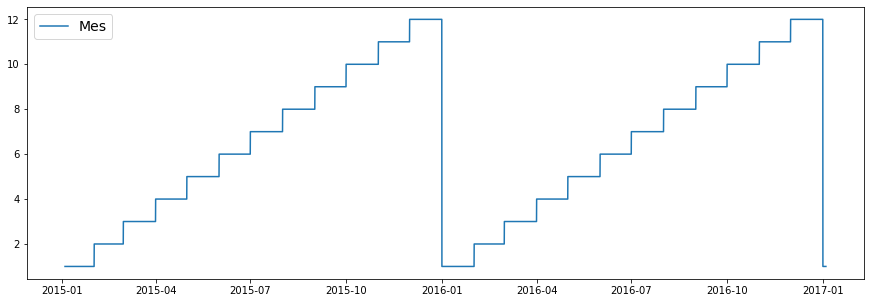

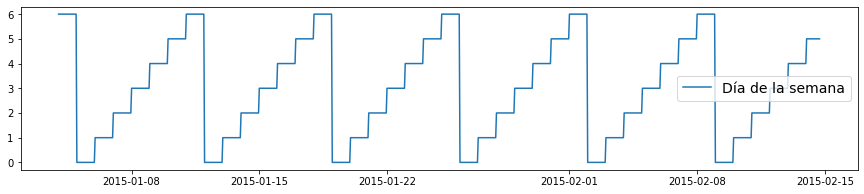

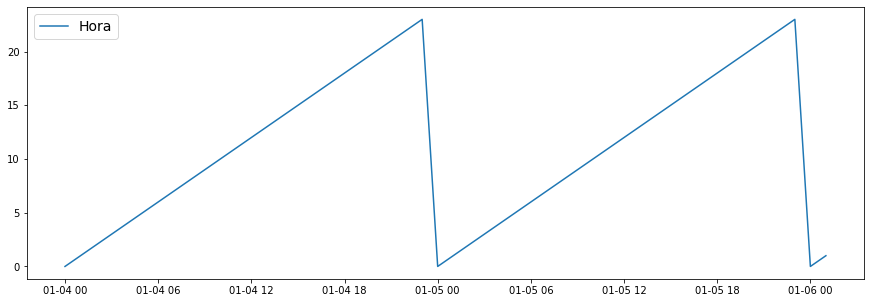

In [18]:
plt.figure(figsize=(15,5))
plt.plot(timestamp, mes, label='Mes')
plt.legend(fontsize=14);
plt.figure(figsize=(15,3))
plt.plot(timestamp[:1000], dia[:1000], label='Día de la semana')
plt.legend(fontsize=14);
plt.figure(figsize=(15,5))
plt.plot(timestamp[0:50], hora[0:50], label='Hora')
plt.legend(fontsize=14);

In [19]:
def encode_ciclicas(v, n_valores):
    x = np.cos(v/n_valores * 2*np.pi)
    y = np.sin(v/n_valores * 2*np.pi)
    return x, y

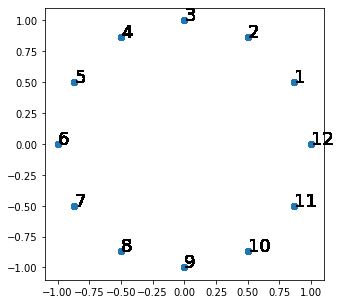

In [20]:
coords_x_mes, coords_y_mes = encode_ciclicas(mes, 12)
plt.figure(figsize=(5,5))
plt.plot(coords_x_mes, coords_y_mes, "o")
for cx,cy,texto in zip(coords_x_mes, coords_y_mes, mes):
    plt.text(cx,cy,texto, fontsize=18)

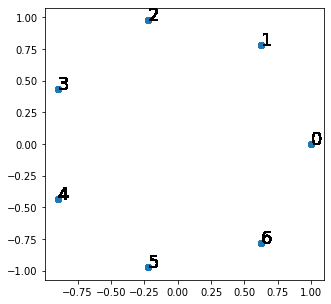

In [21]:
coords_x_day_of_week, coords_y_day_of_week = encode_ciclicas(dia, 7)
plt.figure(figsize=(5,5))
plt.plot(coords_x_day_of_week, coords_y_day_of_week, "o")
for cx,cy,texto in zip(coords_x_day_of_week, coords_y_day_of_week, dia):
    plt.text(cx,cy,texto, fontsize=18)

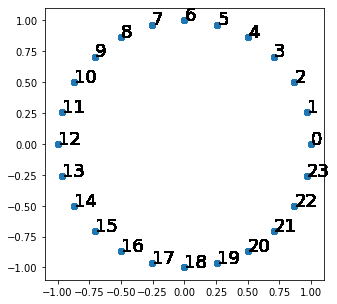

In [22]:
coords_x_hora, coords_y_hora = encode_ciclicas(hora, 24)
plt.figure(figsize=(5,5))
plt.plot(coords_x_hora, coords_y_hora, "o")
for cx,cy,texto in zip(coords_x_hora, coords_y_hora, hora):
    plt.text(cx,cy,texto, fontsize=18)

In [158]:

from sklearn.preprocessing import RobustScaler
f_columns = ['t1', 'hum', 'wind_speed']
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(data[f_columns].to_numpy())
data.loc[:, f_columns] = f_transformer.transform(data[f_columns].to_numpy())

In [151]:
d = data.cnt.std()

In [152]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/d #x/data.cnt.std()
def inverse_transform(x_escalado):
    return x_escalado*d #data.cnt.std()

In [153]:
def inverse_transform(x_escalado):
    return x_escalado*1085.10 #data.cnt.std()

In [154]:
data['cnt'] = transform(data['cnt'])

In [155]:
data['cnt'].max()

7.243518164000965

In [159]:
data.t1.max()

2.6875

In [157]:
data.head(5)

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                                  
2015-01-04 00:00:00  0.167725  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00  0.127176  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00  0.123490  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00  0.066353  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00  0.043314  2.0  0.0   93.0         6.5           1.0   

                     is_holiday  is_weekend  season  hour  day_of_week  \
timestamp                                                                
2015-01-04 00:00:00         0.0         1.0     3.0     0            6   
2015-01-04 01:00:00         0.0         1.0     3.0     1            6   
2015-01-04 02:00:00         0.0         1.0     3.0     2            6   
2015-01-04 03:00:00         0.0         1.0     3.0     3            6   
2015-01-04 04:00:00         0.0         1.0     3.0     4            6   

                     day_of_month  month  year  
timestamp                                       
2015-01-04 00:00:00             4      1  2015  
2015-01-04 01:00:00             4      1  2015  
2015-01-04 02:00:00             4      1  2015  
2015-01-04 03:00:00             4      1  2015  
2015-01-04 04:00:00             4      1  2015

In [160]:
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

estacion = data['season'].values
festivo = data['is_holiday'].values
timestamp = data["timestamp"].values
year_month = data["year_month"].values

KeyError: ignored

In [145]:
cnt	t1	t2	hum	wind_speed	weather_code	is_holiday	is_weekend	season	hour	day_of_week	day_of_month	month	year	year_month

SyntaxError: ignored

In [148]:
data

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                                     
2015-01-04 00:00:00  1318.320306  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00   999.605507  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00   970.631434  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00   521.533308  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00   340.445354  2.0  0.0   93.0         6.5           1.0   
...                          ...  ...  ...    ...         ...           ...   
2017-01-03 19:00:00  7547.745927  5.0  1.0   81.0        19.0           3.0   
2017-01-03 20:00:00  3918.743327  5.0  1.0   81.0        21.0           4.0   
2017-01-03 21:00:00  2441.065621  5.5  1.5   78.5        24.0           4.0   
2017-01-03 22:00:00  1622.548069  5.5  1.5   76.0        23.0           4.0   
2017-01-03 23:00:00  1006.849025  5.0  1.0   76.0        22.0           2.0   

                     is_holiday  is_weekend  season  hour  day_of_week  \
timestamp                                                                
2015-01-04 00:00:00         0.0         1.0     3.0     0            6   
2015-01-04 01:00:00         0.0         1.0     3.0     1            6   
2015-01-04 02:00:00         0.0         1.0     3.0     2            6   
2015-01-04 03:00:00         0.0         1.0     3.0     3            6   
2015-01-04 04:00:00         0.0         1.0     3.0     4            6   
...                         ...         ...     ...   ...          ...   
2017-01-03 19:00:00         0.0         0.0     3.0    19            1   
2017-01-03 20:00:00         0.0         0.0     3.0    20            1   
2017-01-03 21:00:00         0.0         0.0     3.0    21            1   
2017-01-03 22:00:00         0.0         0.0     3.0    22            1   
2017-01-03 23:00:00         0.0         0.0     3.0    23            1   

                     day_of_month  month  year  
timestamp                                       
2015-01-04 00:00:00             4      1  2015  
2015-01-04 01:00:00             4      1  2015  
2015-01-04 02:00:00             4      1  2015  
2015-01-04 03:00:00             4      1  2015  
2015-01-04 04:00:00             4      1  2015  
...                           ...    ...   ...  
2017-01-03 19:00:00             3      1  2017  
2017-01-03 20:00:00             3      1  2017  
2017-01-03 21:00:00             3      1  2017  
2017-01-03 22:00:00             3      1  2017  
2017-01-03 23:00:00             3      1  2017  

[17414 rows x 14 columns]

In [161]:
target_transf = transform(target)

series = [target_transf, t1, hum, viento, festivo]
se_saben_antes = [False, True, True, True, True]
nombres_series = ["target_transf", "t1", "hum", "wind_speed", "is_holiday"]

# Variables calendario sobre las que hemos la transformación cíclica
series.append(coords_x_mes)
nombres_series.append("coords_x_mes")
se_saben_antes.append(True)

series.append(coords_y_mes)
nombres_series.append("coords_y_mes")
se_saben_antes.append(True)

series.append(coords_x_hora)
nombres_series.append("coords_x_hora")
se_saben_antes.append(True)

series.append(coords_y_hora)
nombres_series.append("coords_y_hora")
se_saben_antes.append(True)

series.append(coords_x_day_of_week)
nombres_series.append("coords_x_dia")
se_saben_antes.append(True)

series.append(coords_y_day_of_week)
nombres_series.append("coords_y_dia")
se_saben_antes.append(True)

In [162]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(11, 17414)
(11,)


In [163]:
series

[array([2.94595627e-06, 2.23374706e-06, 2.16900077e-06, ...,
        5.45487507e-06, 3.62579233e-06, 2.24993364e-06]),
 array([-1.1875, -1.1875, -1.25  , ..., -0.875 , -0.875 , -0.9375]),
 array([0.925, 0.925, 1.1  , ..., 0.2  , 0.075, 0.075]),
 array([-0.85714286, -0.95238095, -1.42857143, ...,  0.85714286,
         0.76190476,  0.66666667]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.8660254, 0.8660254, 0.8660254, ..., 0.8660254, 0.8660254,
        0.8660254]),
 array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 array([1.        , 0.96592583, 0.8660254 , ..., 0.70710678, 0.8660254 ,
        0.96592583]),
 array([ 0.        ,  0.25881905,  0.5       , ..., -0.70710678,
        -0.5       , -0.25881905]),
 array([0.6234898, 0.6234898, 0.6234898, ..., 0.6234898, 0.6234898,
        0.6234898]),
 array([-0.78183148, -0.78183148, -0.78183148, ...,  0.78183148,
         0.78183148,  0.78183148])]

In [164]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [165]:
lookback = 48 # lookback es otro sinónimo de W_in (LAG)
time_step = 24 # valores a predecir (N_AHEAD, N_OUTPUTS)

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback, W_out = time_step)

print(X.shape, np.shape(y))

(17414, 48, 11) (17414, 24)


In [166]:
print(X.shape)
print(np.shape(target))

(17414, 48, 11)
(17414,)


In [167]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=timestamp)

10 ventanas creadas

X.shape=(10, 48, 11)  Y.shape=(10, 24) 

 Ventana 0: 


X[0].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 ?43 
 ?44 
 ?45 
 ?46 
 ?47 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.781831 
 
 
 
__
 
 Y[0].shape=(24,) 
 
 
   
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015-01-04 06:00:00 
 2015-01-04 07:00:00 
 2015-01-04 08:00:00 
 2015-01-04 09:00:00 
 2015-01-04 10:00:00 

 Ventana 1: 


X[1].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 ?43 
 ?44 
 ?45 
 ?46 
 2015-01-04 00:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.781831 
 -0.781831 
 
 
 
__
 
 Y[1].shape=(24,) 
 
 
   
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015-01-04 06:00:00 
 2015-01-04 07:00:00 
 2015-01-04 0

 Ventana 2: 


X[2].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 ?43 
 ?44 
 ?45 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.781831 
 -0.781831 
 -0.781831 
 
 
 
__
 
 Y[2].shape=(24,) 
 
 
   
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015

 Ventana 3: 


X[3].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 ?43 
 ?44 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.781831 
 -0.781831 
 -0.781831 
 -0.781831 
 
 
 
__
 
 Y[3].shape=(24,) 
 
 
   
 2015-01-04 03:00:0

 Ventana 4: 


X[4].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 ?43 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.781831 
 -0.781831 
 -0.781831 
 -0.781

 Ventana 5: 


X[5].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 ?42 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 0.000001 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 -1.312500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 0.925000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 -1.047619 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 0.258819 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 0.965926 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 

 Ventana 6: 


X[6].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 ?41 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 0.000001 
 0.000001 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 -1.312500 
 -1.437500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 0.925000 
 1.275000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 -1.047619 
 -0.761905 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 0.258819 
 0.000000 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 0.965926 
 1.000000 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 na

 Ventana 7: 


X[7].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 ?40 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015-01-04 06:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 0.000001 
 0.000001 
 0.000001 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 -1.312500 
 -1.437500 
 -1.437500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 0.925000 
 1.275000 
 1.275000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 -1.047619 
 -0.761905 
 -0.761905 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 0.258819 
 0.000000 
 -0.258819 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 0.965926 
 1.000000 
 0.965926 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 


 Ventana 8: 


X[8].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 ?39 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015-01-04 06:00:00 
 2015-01-04 07:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 0.000001 
 0.000001 
 0.000001 
 0.000001 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 -1.312500 
 -1.437500 
 -1.437500 
 -1.375000 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 0.925000 
 1.275000 
 1.275000 
 1.100000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 -1.047619 
 -0.761905 
 -0.761905 
 -0.666667 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 0.258819 
 0.000000 
 -0.258819 
 -0.500000 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 0.965926 
 1.000000 
 0.965926 
 0.866025 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 
 
 coords_y_dia 
 nan 
 nan 
 nan 
 nan 
 na

 Ventana 9: 


X[9].shape=(48, 11) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 ?6 
 ?7 
 ?8 
 ?9 
 ?10 
 ?11 
 ?12 
 ?13 
 ?14 
 ?15 
 ?16 
 ?17 
 ?18 
 ?19 
 ?20 
 ?21 
 ?22 
 ?23 
 ?24 
 ?25 
 ?26 
 ?27 
 ?28 
 ?29 
 ?30 
 ?31 
 ?32 
 ?33 
 ?34 
 ?35 
 ?36 
 ?37 
 ?38 
 2015-01-04 00:00:00 
 2015-01-04 01:00:00 
 2015-01-04 02:00:00 
 2015-01-04 03:00:00 
 2015-01-04 04:00:00 
 2015-01-04 05:00:00 
 2015-01-04 06:00:00 
 2015-01-04 07:00:00 
 2015-01-04 08:00:00 
 
 
 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000003 
 0.000002 
 0.000002 
 0.000001 
 0.000001 
 0.000001 
 0.000001 
 0.000001 
 0.000002 
 
 
 t1 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -1.187500 
 -1.187500 
 -1.250000 
 -1.312500 
 -1.312500 
 -1.312500 
 -1.437500 
 -1.437500 
 -1.375000 
 -1.312500 
 
 
 hum 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.925000 
 0.925000 
 1.100000 
 1.275000 
 0.925000 
 0.925000 
 1.275000 
 1.275000 
 1.100000 
 1.275000 
 
 
 wind_speed 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.857143 
 -0.952381 
 -1.428571 
 -1.428571 
 -0.809524 
 -1.047619 
 -0.761905 
 -0.761905 
 -0.666667 
 -0.571429 
 
 
 is_holiday 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 0.500000 
 0.258819 
 0.000000 
 -0.258819 
 -0.500000 
 -0.707107 
 
 
 coords_y_hora 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.258819 
 0.500000 
 0.707107 
 0.866025 
 0.965926 
 1.000000 
 0.965926 
 0.866025 
 0.707107 
 
 
 coords_x_dia 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 
 0.623490 

In [168]:
y.shape

(17414, 24)

In [169]:
y2 = y[:-24] #elimino los últimos time_step al tener NAN
X2 = X[:-24]#elimino los últimos time_step al tener NAN
target2 = target[:-24] #elimino los últimos time_step al tener NAN
timestamp2 = timestamp[:-24] #elimino los últimos time_step al tener NAN

In [170]:
print(y2.shape)
print(X2.shape)
print(target2.shape)
print(timestamp2.shape)

(17390, 24)
(17390, 48, 11)
(17390,)
(17390,)


 Separación training-test

In [171]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)


X_train      = X2[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y2[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target2[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = timestamp2[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = timestamp2[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(13883,)
(3483,)


In [172]:
len(target_test) + len(target_train)

17366

In [173]:
print(X_train.shape, y_train.shape)

(13883, 48, 11) (13883, 24)


In [174]:
lookback, X_train.shape[-1]

(48, 11)

 Construcción del modelo con Keras

In [112]:
def vanilla_multistep_LSTM():
    model = Sequential()  
    model.add(LSTM(units=50, input_shape=(lookback, X_train.shape[-1])))
    model.add(Dense(time_step))
    return model

In [113]:
loss = 'mean_squared_error'
optimizer = "adam"

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

In [ ]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer=optimizer, 
              loss=loss,
              metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

In [ ]:
history_model_0 = model.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

In [ ]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
109/109 [==============================] - 1s 11ms/step - loss: nan - mse: nan 
Test MSE: nan
Test MAE: nan


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

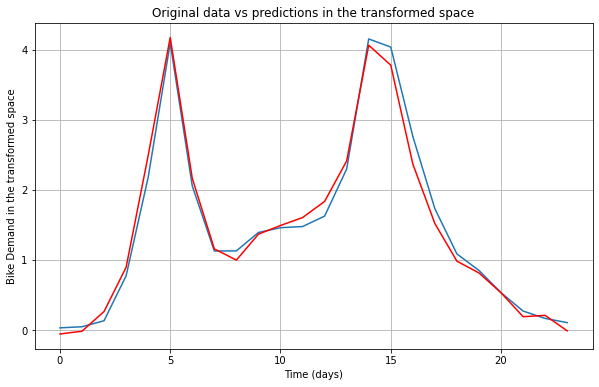

In [ ]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Bike Demand in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
epochs = 25
batch_size = 32
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)


Epoch 1: val_mse improved from inf to 0.11979, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.11979

Epoch 1: val_mse improved from 0.11979 to 0.11491, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.11491 to 0.11277, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not imp

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))  # input_shape=[time steps, features]
model_0.add(Dense(100, activation='relu'))
model_0.add(Dense(n_outputs))
model_0.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

In [ ]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               169600    
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 24)                2424      
                                                                 
Total params: 192,124
Trainable params: 192,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_model_0 = model_0.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
391/391 [==============================] - 45s 110ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/35
159/391 [===========>..................] - ETA: 23s - loss: nan - mse: nan

KeyboardInterrupt: ignored

probando

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

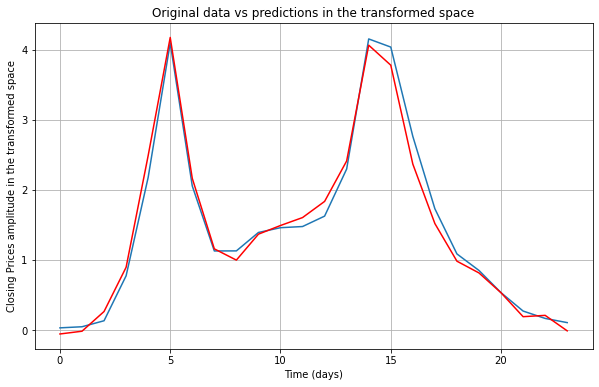

In [ ]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_hour = 0
y_pred_hour = y_pred[the_day,:]


In [ ]:
y_pred

array([[-0.05594212, -0.01673202,  0.26441845, ...,  0.19075108,
         0.20941885, -0.01141405],
       [ 0.01078567,  0.19675684,  0.7828093 , ...,  0.12865308,
        -0.02761573, -0.02626342],
       [ 0.15965058,  0.79480594,  2.4489532 , ...,  0.07361817,
         0.20814891,  0.09050679],
       ...,
       [ 0.45599782,  0.38918313,  0.3346392 , ...,  1.9591632 ,
         1.0967755 ,  0.5487582 ],
       [ 0.29884946,  0.22998245,  0.1809567 , ...,  1.0417607 ,
         0.6263505 ,  0.45428747],
       [ 0.22318567,  0.12923798,  0.05836874, ...,  0.66363704,
         0.40307012,  0.17764473]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

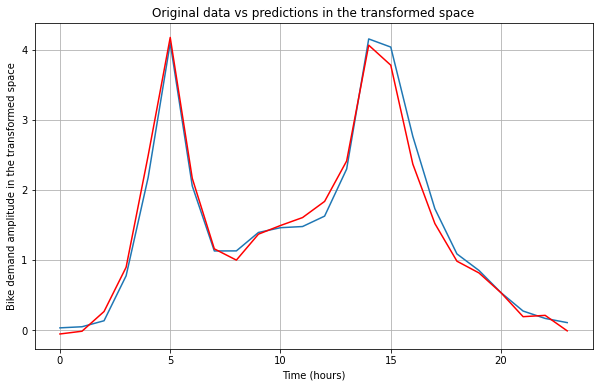

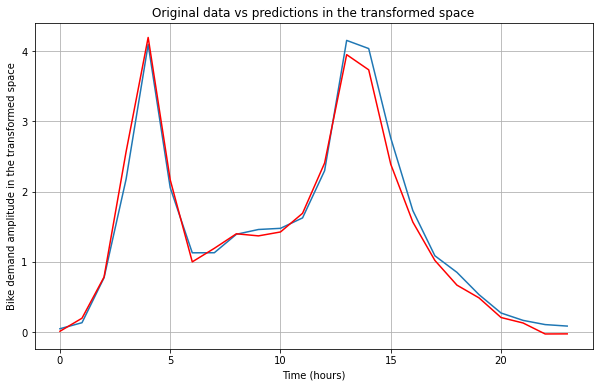

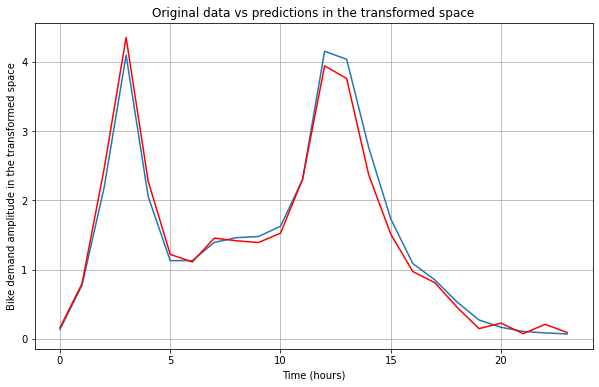

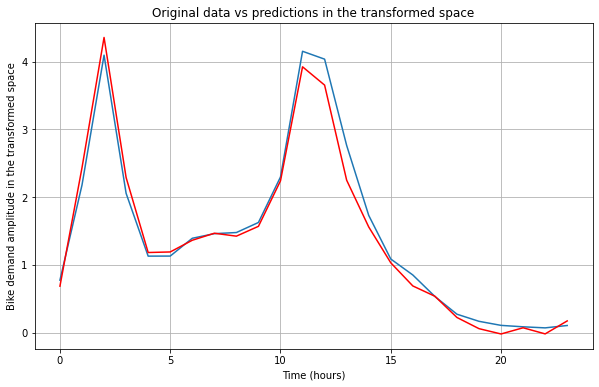

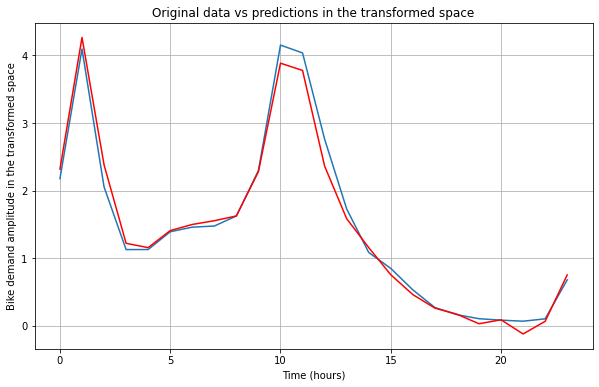

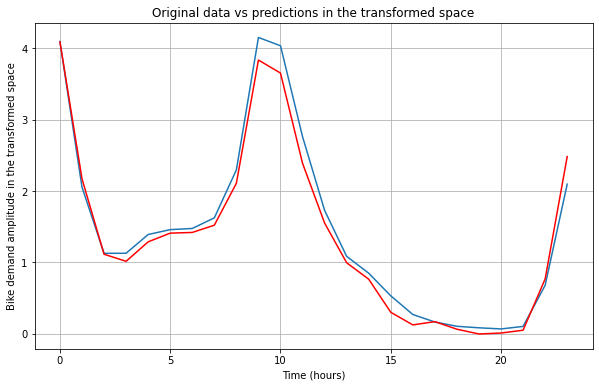

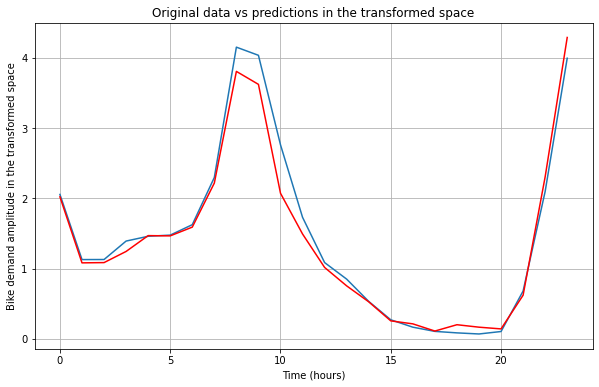

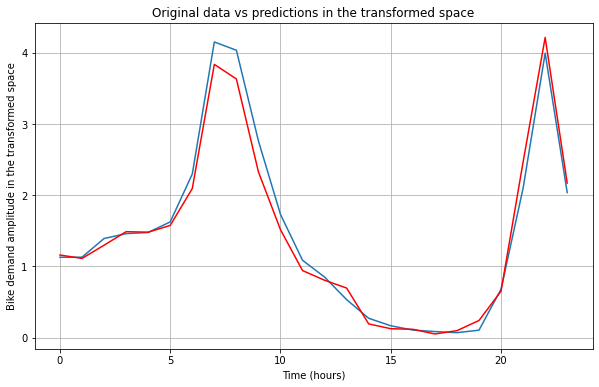

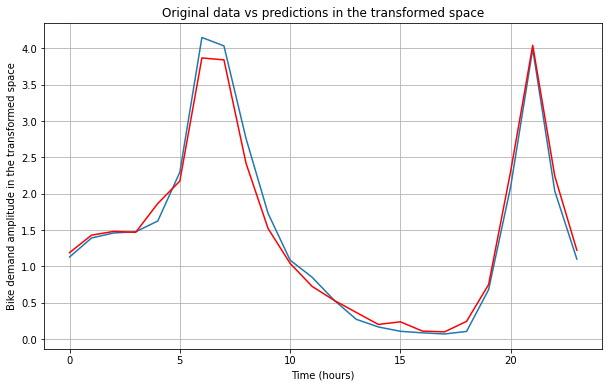

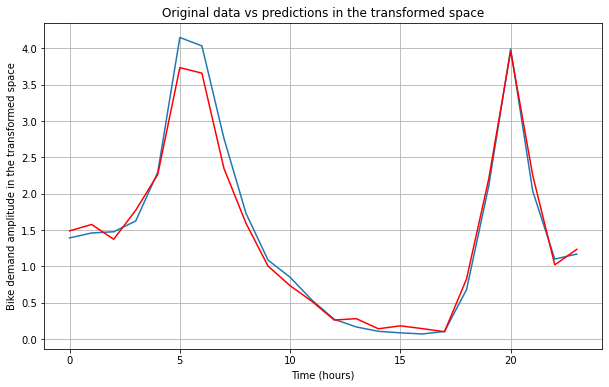

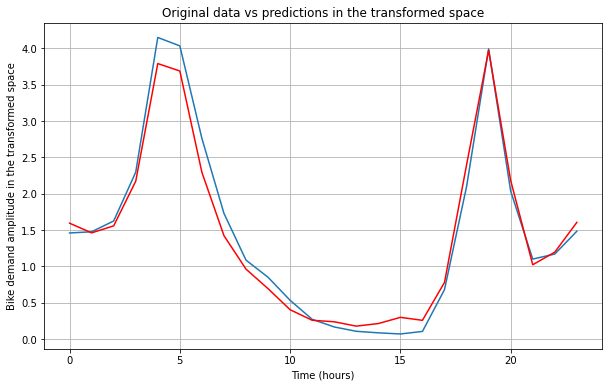

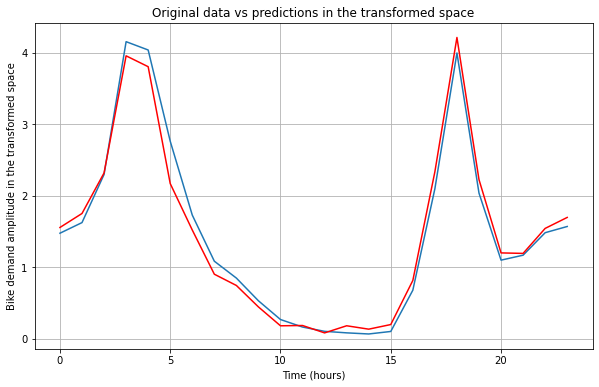

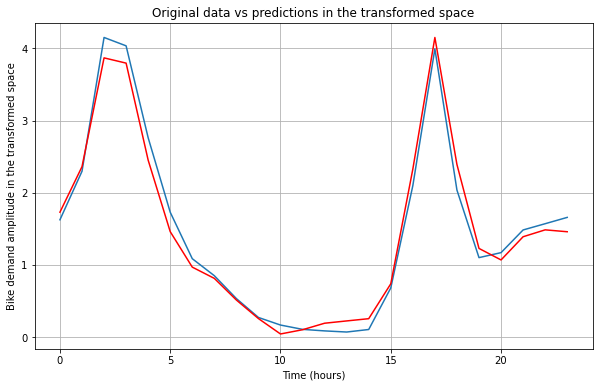

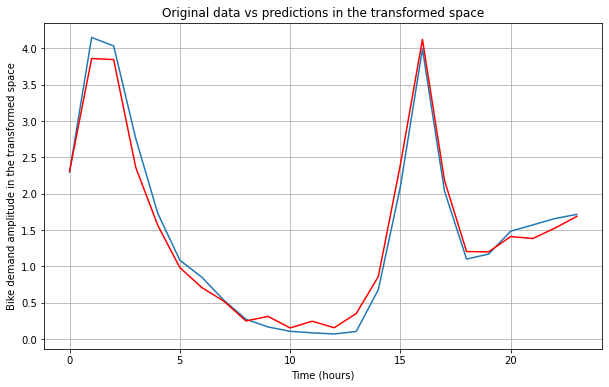

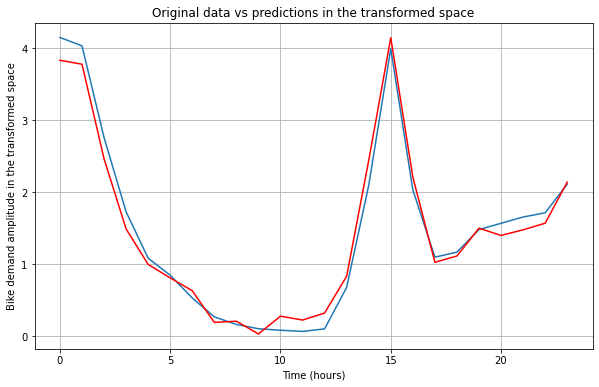

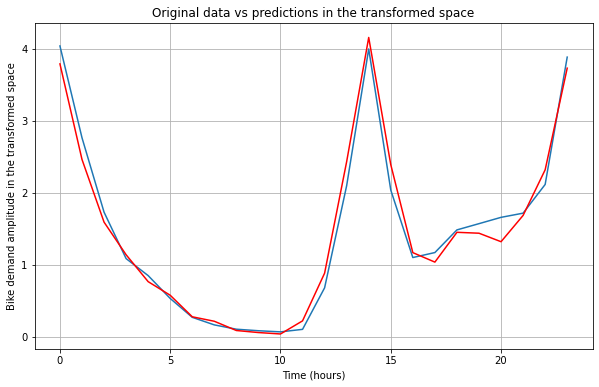

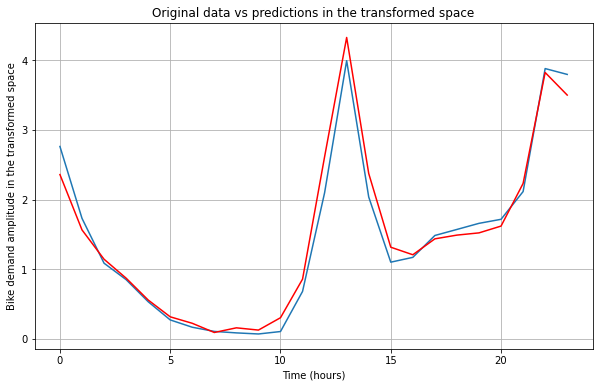

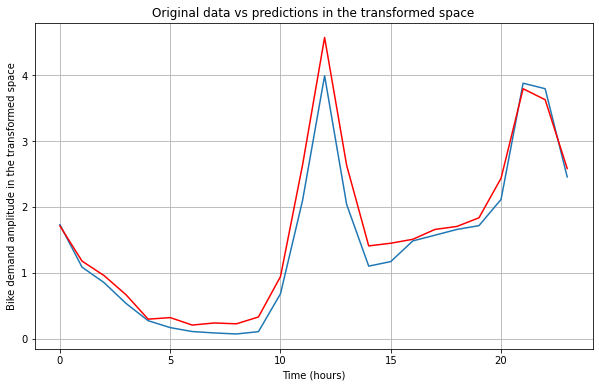

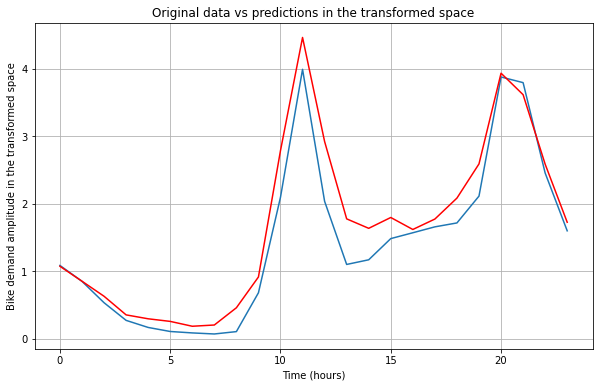

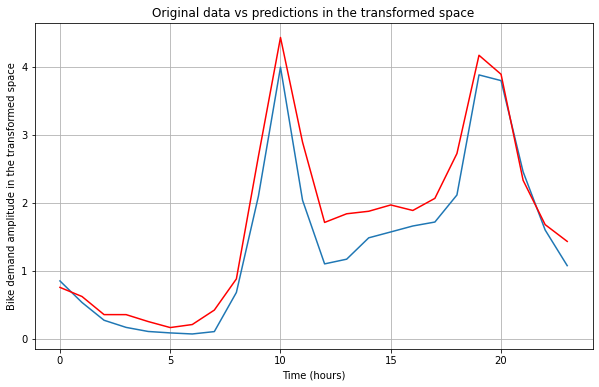

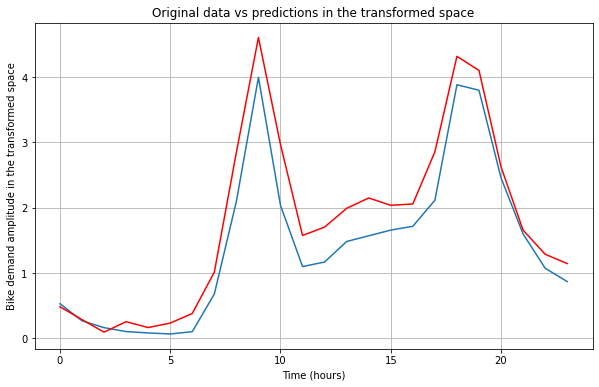

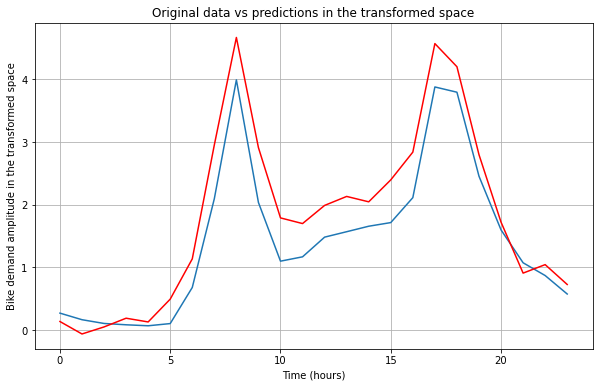

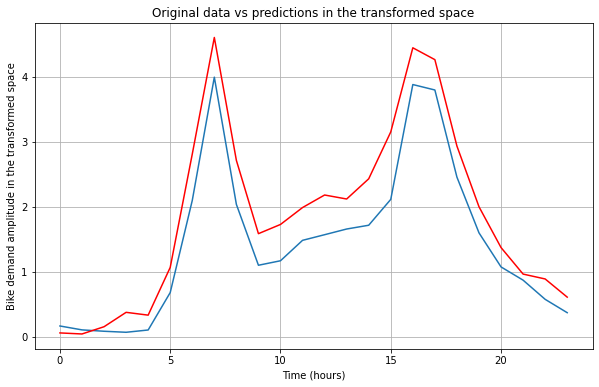

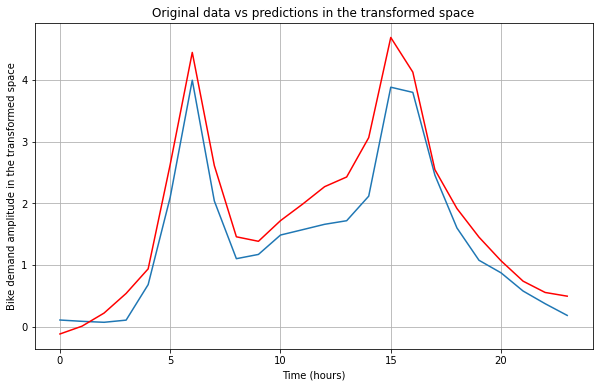

In [ ]:
for i in range(0,24):
  the_hour = i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

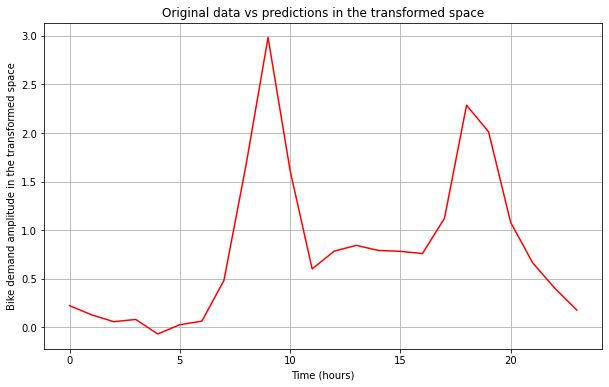

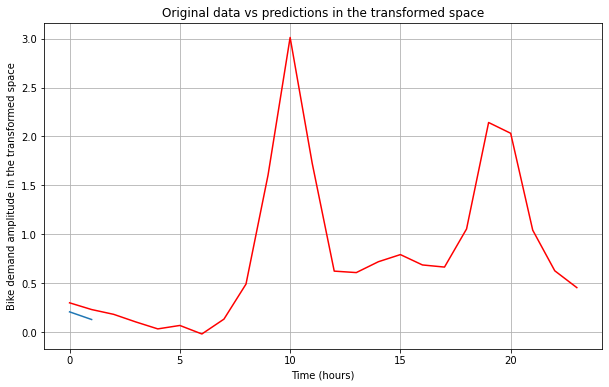

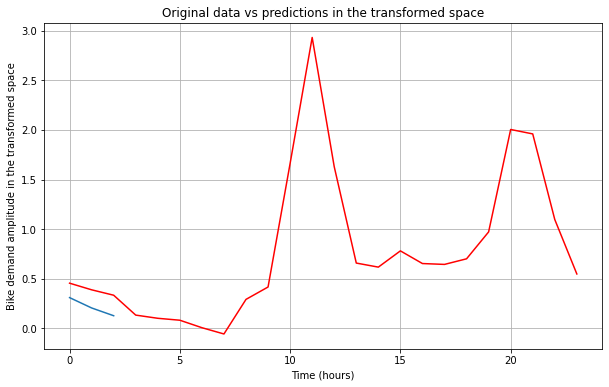

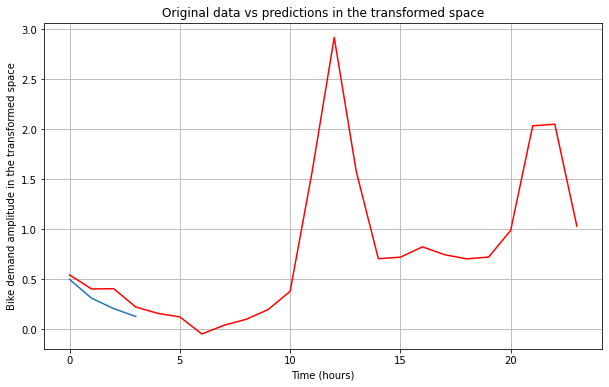

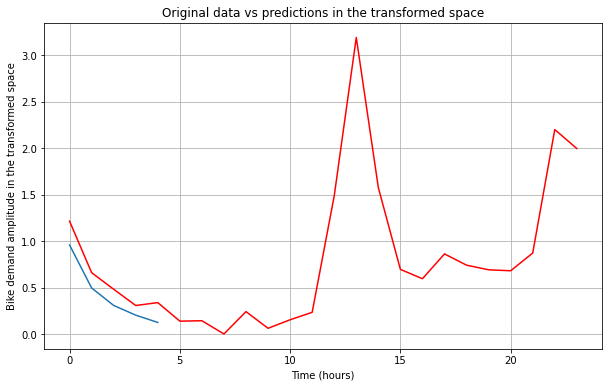

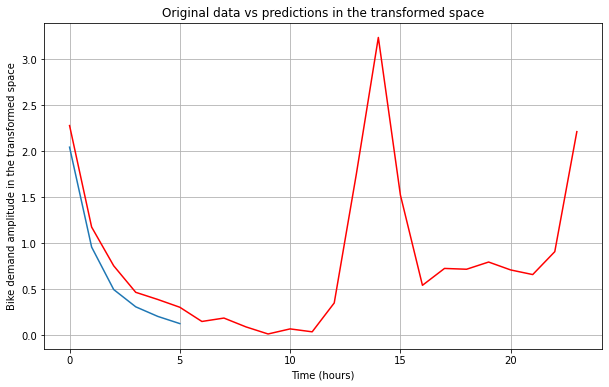

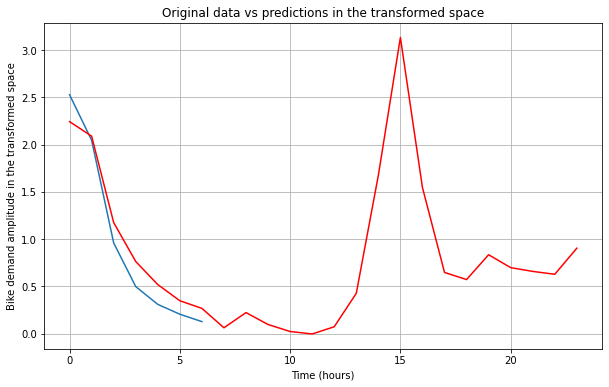

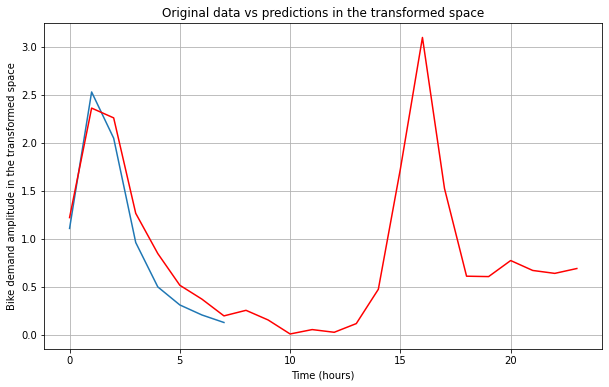

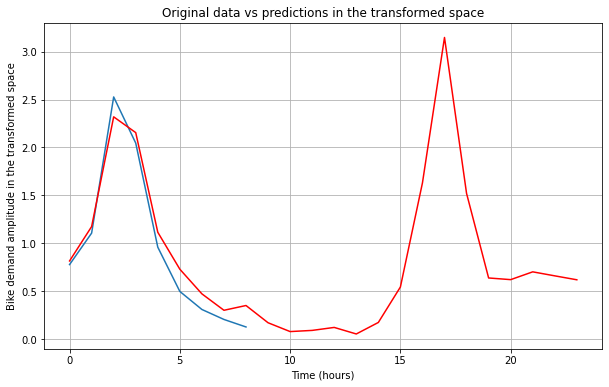

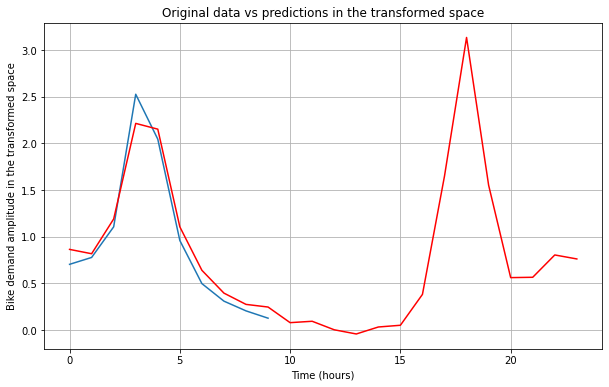

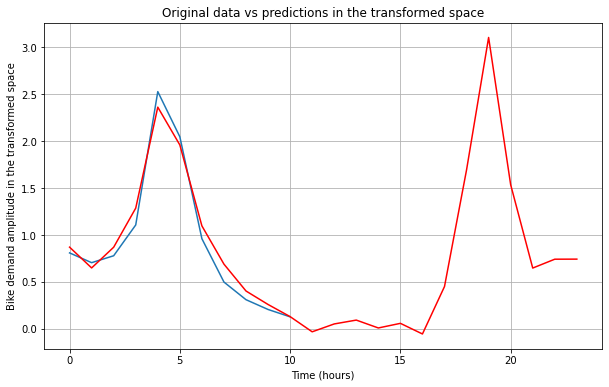

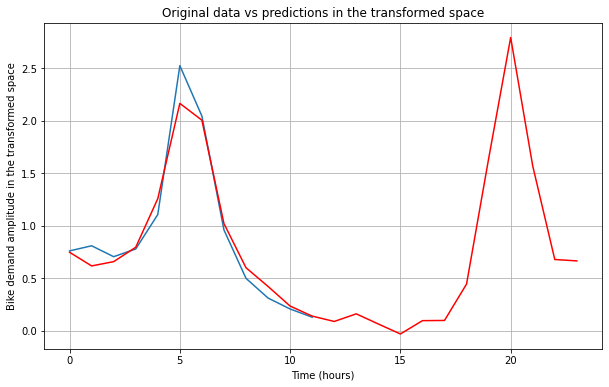

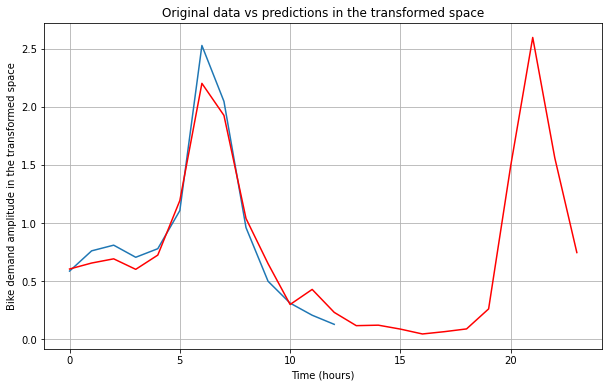

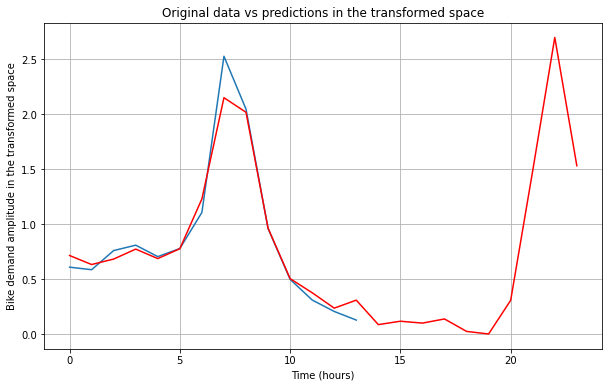

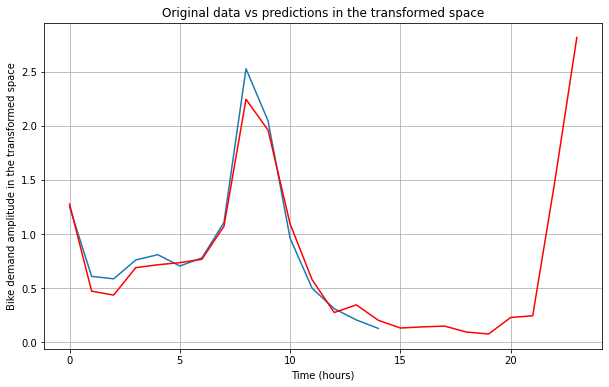

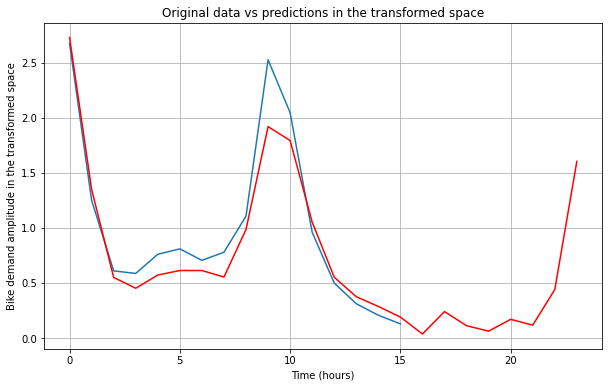

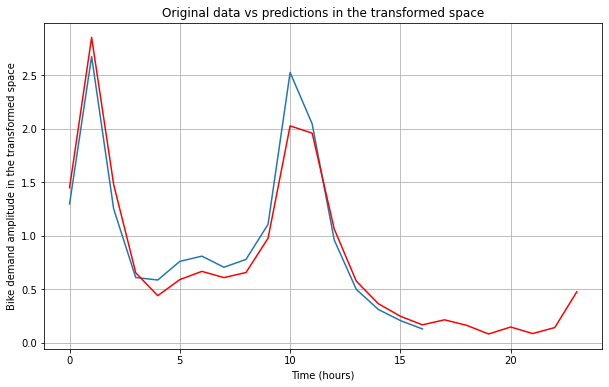

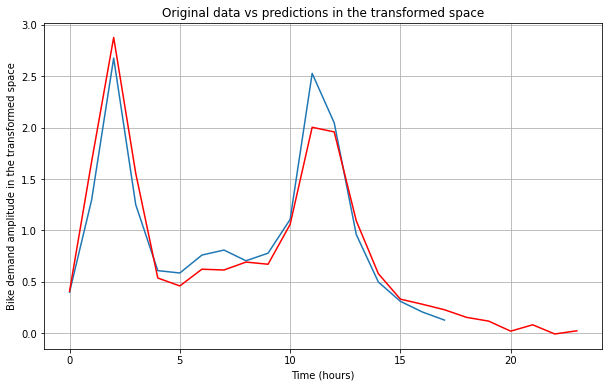

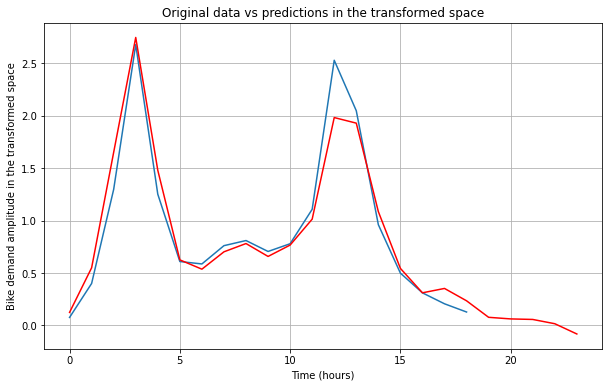

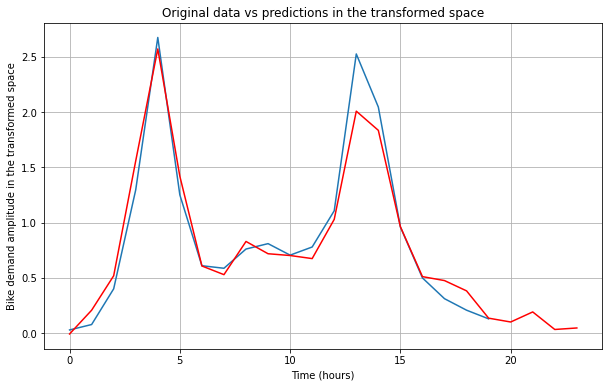

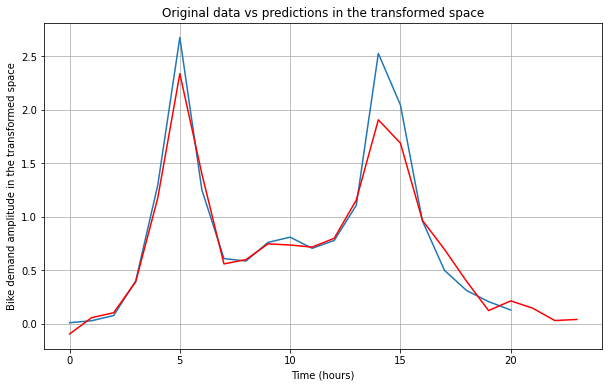

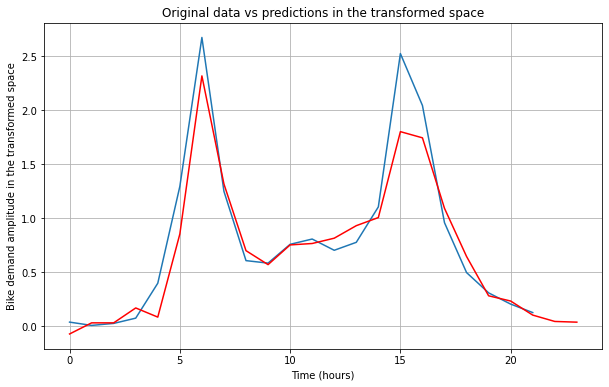

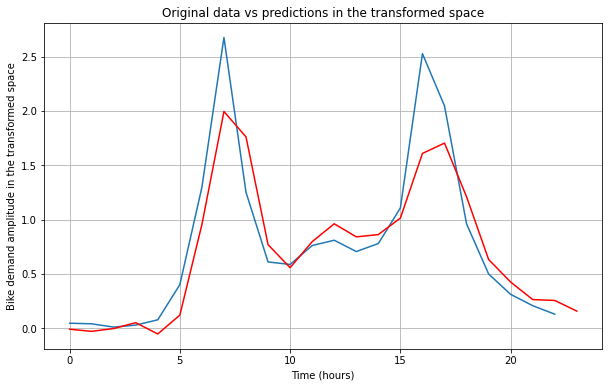

In [ ]:
for i in range(1,24):
  the_hour = -i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

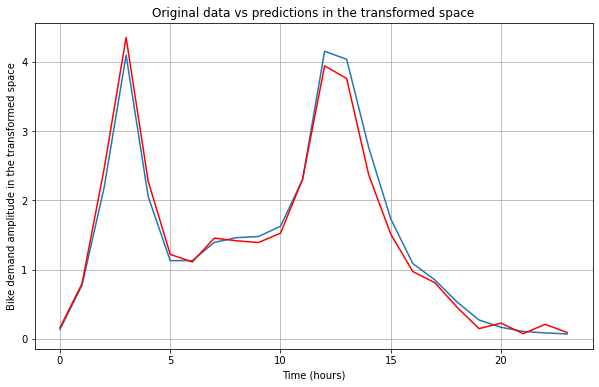

In [ ]:
the_day = 2
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

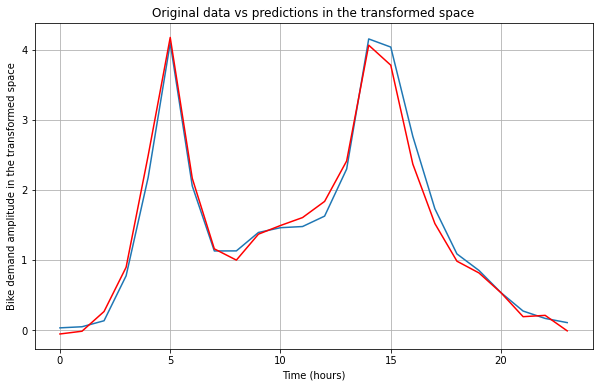

In [ ]:
the_day = 0
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

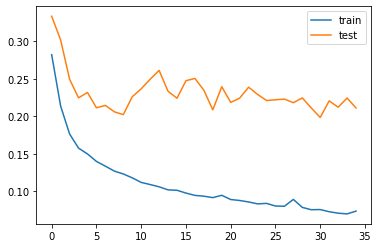

In [ ]:
plt.plot(history_model_0.history['loss'], label='train')
plt.plot(history_model_0.history['val_loss'], label='test')
plt.legend();

In [ ]:
# R2 scores y_pred
print("R2 del modelo en training      : ",
      R2_score(y_train, y_pred))

ValueError: ignored

Chequeo

In [ ]:
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

In [ ]:
y_train_prediction.shape

(13883, 24)

In [ ]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

In [ ]:
y_test_inv = inverse_transform(y_test)

In [ ]:
target_train_pred.shape

(13883, 24)

In [ ]:
y_train_prediction

array([[ 0.11859745,  0.12764654,  0.04211043, ...,  0.56862533,
         0.41495246,  0.29291603],
       [ 0.02799015,  0.0485474 ,  0.04224458, ...,  0.48202094,
         0.2922027 ,  0.19090441],
       [ 0.0343588 ,  0.04386388, -0.00711916, ...,  0.31824735,
         0.12140697,  0.11433038],
       ...,
       [ 0.1472924 ,  0.06550334,  0.11861002, ...,  0.80561507,
         0.70152545,  0.7037877 ],
       [-0.02739336, -0.00685152, -0.03452538, ...,  0.57948756,
         0.3002407 ,  0.2859222 ],
       [-0.15073834, -0.00273833,  0.04724509, ...,  0.449693  ,
         0.14806886,  0.15408781]], dtype=float32)

In [ ]:
target_train_pred

array([[ 128.6901   ,  138.50925  ,   45.694023 , ...,  617.0153   ,
         450.2649   ,  317.84317  ],
       [  30.372108 ,   52.678783 ,   45.839596 , ...,  523.0409   ,
         317.06915  ,  207.15038  ],
       [  37.282734 ,   47.59669  ,   -7.7250047, ...,  345.3302   ,
         131.73871  ,  124.05989  ],
       ...,
       [ 159.82698  ,   71.077675 ,  128.70374  , ...,  874.1729   ,
         761.2252   ,  763.68     ],
       [ -29.72453  ,   -7.4345884,  -37.46349  , ...,  628.80194  ,
         325.79117  ,  310.25418  ],
       [-163.56618  ,   -2.9713583,   51.26564  , ...,  487.96185  ,
         160.66951  ,  167.20068  ]], dtype=float32)

In [ ]:
# Parece que me salen predicciones negativas y no pueden haberlas, como mucho tendríamos predicciones en 0 (días de tormenta)

In [ ]:
resultsDict = {}

resultsDict['LSTM'] = evaluate(y_test_prediction, target_test_pred)
evaluate(y_test_prediction, target_test_pred)

NameError: ignored

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

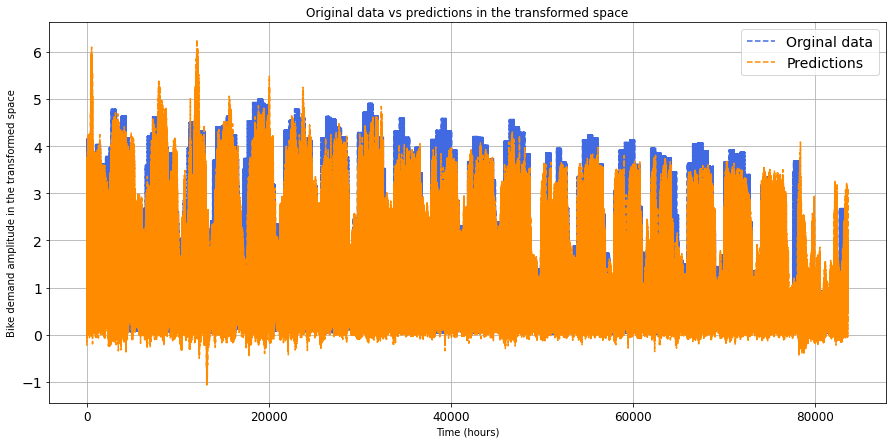

In [ ]:
y_ = y_test.flatten()
y_pred_days_ = y_pred_days.flatten()

plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(y_test.flatten(),'--', c='royalblue', label='Orginal data')
plt.plot(y_test_prediction.flatten(), '--', c='darkorange', label='Predictions')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
#plt.xlim([fechas_train[100],fechas_train[200]])
plt.legend(fontsize=14);

plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [ ]:
add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

modelo 2

In [114]:
def vanilla_multistep_LSTM_2():
    model = Sequential()  
    model.add(LSTM(units=50, input_shape=(lookback, X_train.shape[-1])))
    model.add(Dropout(0.2))
    model.add(Dense(time_step))
    return model

In [115]:
loss = 'mean_squared_error'
optimizer = "adam"

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

In [116]:
model_2 = vanilla_multistep_LSTM_2()

In [117]:
#model_2 = vanilla_multistep_LSTM_2()
model_2.summary()
model_2.compile(optimizer=optimizer, 
              loss=loss,
              metrics=['mse'])

import keras.backend as K
print(K.get_value(model_2.optimizer.lr))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                12400     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 24)                1224      
                                                                 
Total params: 13,624
Trainable params: 13,624
Non-trainable params: 0
_________________________________________________________________
0.001


In [118]:
history_model_2 = model_2.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
391/391 [==============================] - 12s 27ms/step - loss: 55.2258 - mse: 55.2258 - val_loss: 69.8836 - val_mse: 69.8836
Epoch 2/35
391/391 [==============================] - 10s 24ms/step - loss: 39.5897 - mse: 39.5897 - val_loss: 50.3180 - val_mse: 50.3180
Epoch 3/35
391/391 [==============================] - 9s 24ms/step - loss: 30.0839 - mse: 30.0839 - val_loss: 40.5515 - val_mse: 40.5515
Epoch 4/35
391/391 [==============================] - 9s 24ms/step - loss: 26.2173 - mse: 26.2173 - val_loss: 34.6660 - val_mse: 34.6660
Epoch 5/35
391/391 [==============================] - 9s 24ms/step - loss: 22.4509 - mse: 22.4509 - val_loss: 29.3771 - val_mse: 29.3771
Epoch 6/35
391/391 [==============================] - 9s 24ms/step - loss: 19.4717 - mse: 19.4717 - val_loss: 25.1083 - val_mse: 25.1083
Epoch 7/35
391/391 [==============================] - 9s 24ms/step - loss: 17.5189 - mse: 17.5189 - val_loss: 22.3438 - val_mse: 22.3438
Epoch 8/35
391/391 [===================

KeyboardInterrupt: ignored

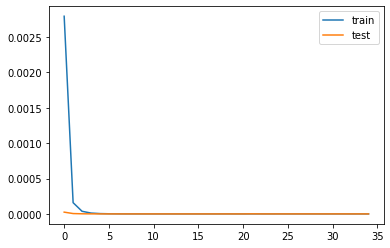

In [87]:
plt.plot(history_model_2.history['loss'], label='train')
plt.plot(history_model_2.history['val_loss'], label='test')
plt.legend();

In [88]:
y_train_prediction = model_2.predict(X_train)
y_test_prediction = model_2.predict(X_test)

In [89]:
y_train_prediction.shape

(13883, 24)

In [90]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

In [91]:
y_test_inv = inverse_transform(y_test)

In [92]:
target_train_pred.shape

(13883, 24)

In [93]:
y_train_prediction

array([[ 8.2138031e-05,  3.7565673e-04,  1.0400207e-04, ...,
        -1.7613658e-05, -1.1618580e-05,  7.7774821e-05],
       [ 7.4062860e-05,  3.5402755e-04,  9.8078817e-05, ...,
        -3.9835169e-05,  7.3584542e-06,  7.6007433e-05],
       [ 6.8609137e-05,  3.3061326e-04,  9.1878377e-05, ...,
        -4.4818917e-05,  2.3785142e-05,  6.7687753e-05],
       ...,
       [ 1.0387175e-04, -3.1050949e-05, -1.0653912e-05, ...,
        -7.4810916e-05,  2.6200069e-06, -8.5968029e-05],
       [ 9.1886781e-05, -6.7798181e-05, -3.2804292e-05, ...,
        -1.0543718e-04,  2.0207466e-05, -7.8056459e-05],
       [ 8.1181875e-05, -1.0025775e-04, -5.1675754e-05, ...,
        -1.2556222e-04,  4.2306303e-05, -7.1574861e-05]], dtype=float32)

In [94]:
target_train_pred

array([[ 0.08912797,  0.4076251 ,  0.11285265, ..., -0.01911258,
        -0.01260732,  0.08439346],
       [ 0.08036561,  0.38415527,  0.10642532, ..., -0.04322514,
         0.00798466,  0.08247566],
       [ 0.07444777,  0.35874844,  0.09969722, ..., -0.04863301,
         0.02580926,  0.07344798],
       ...,
       [ 0.11271124, -0.03369338, -0.01156056, ..., -0.08117732,
         0.00284297, -0.09328391],
       [ 0.09970634, -0.07356781, -0.03559593, ..., -0.11440989,
         0.02192712, -0.08469906],
       [ 0.08809045, -0.10878968, -0.05607336, ..., -0.13624756,
         0.04590657, -0.07766588]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

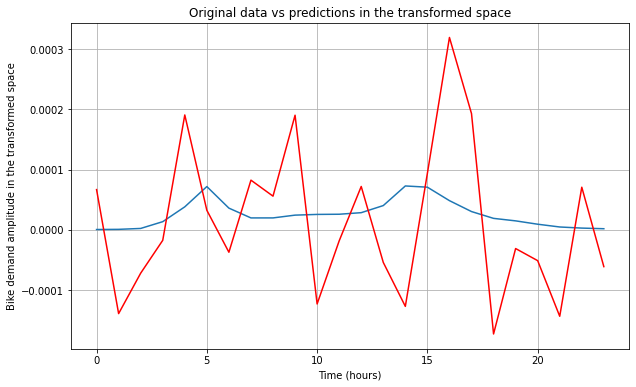

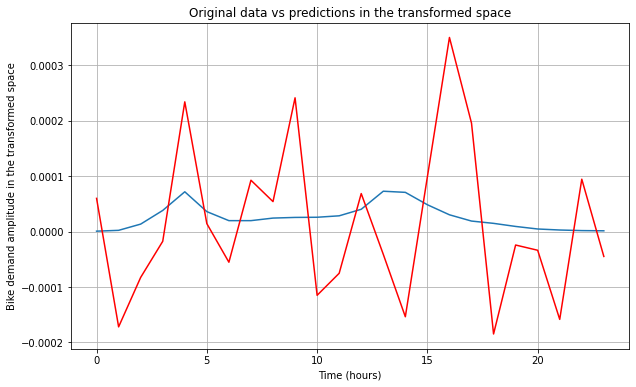

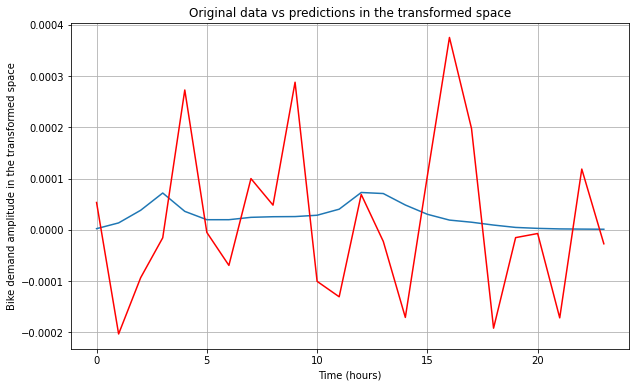

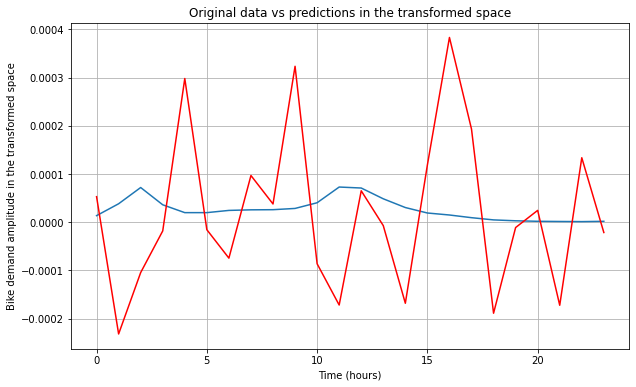

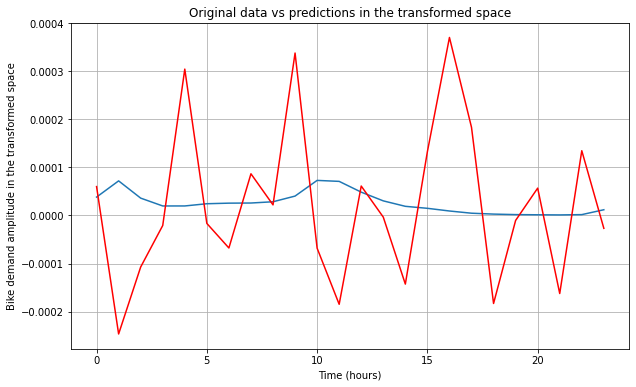

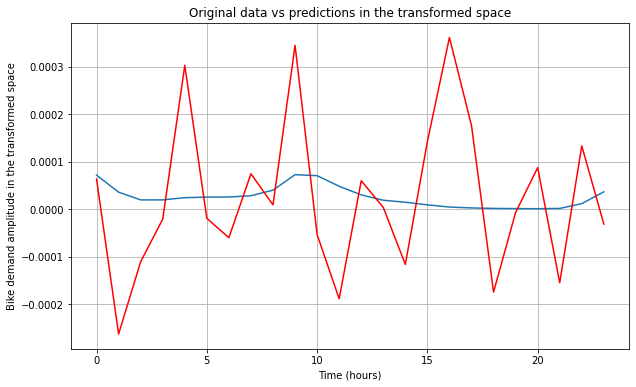

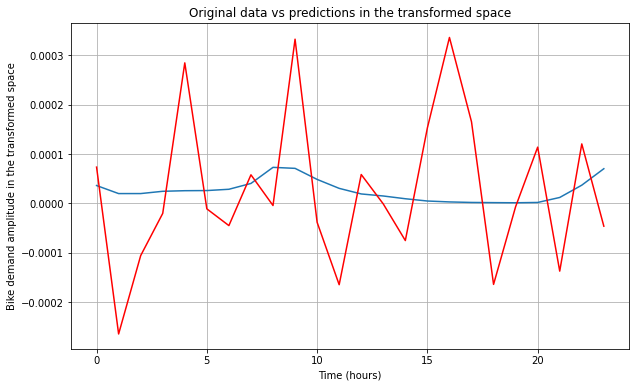

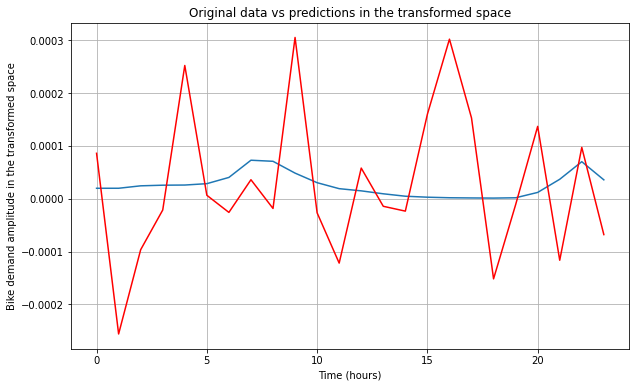

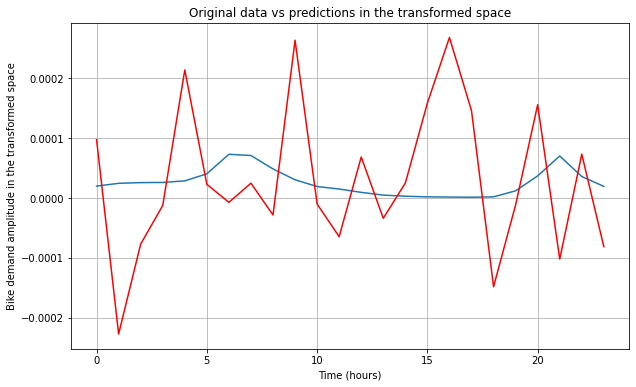

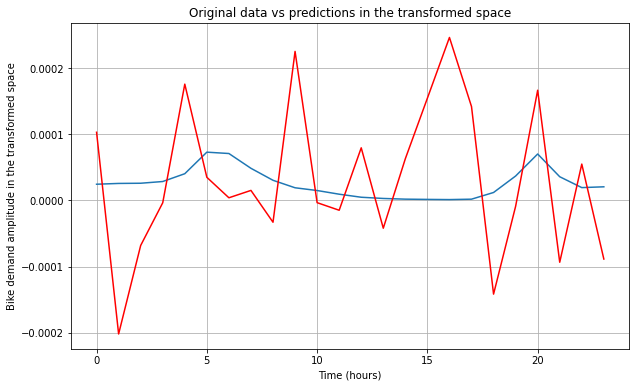

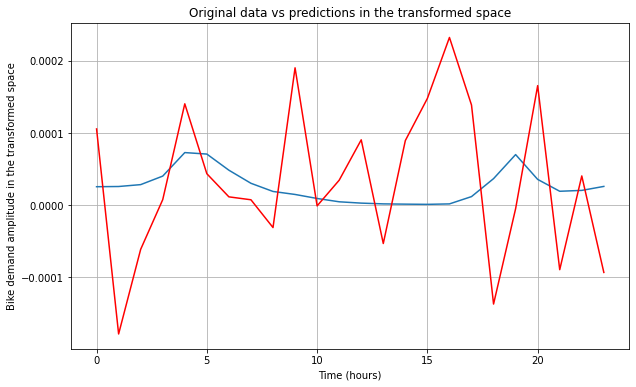

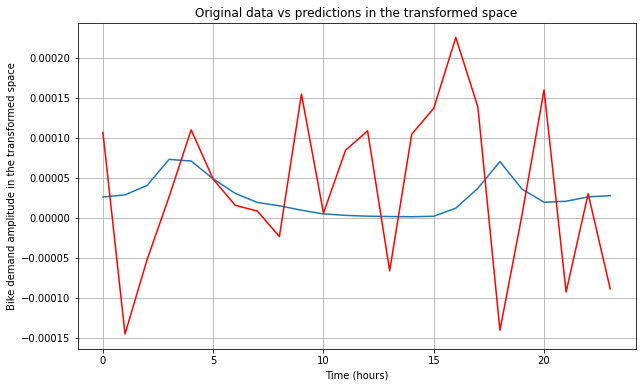

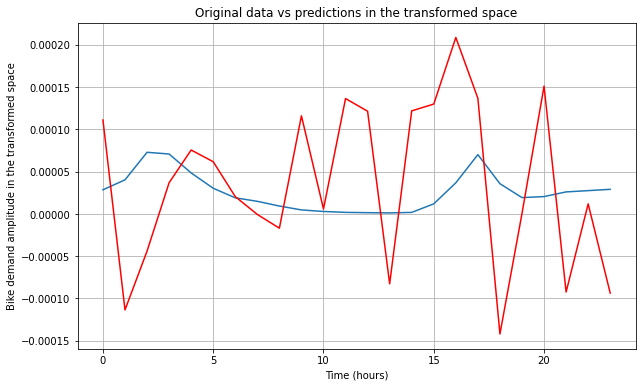

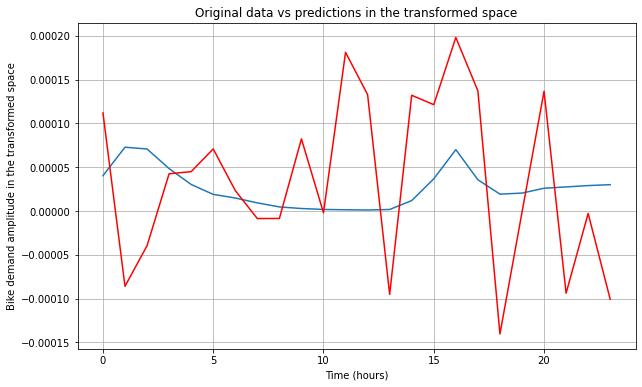

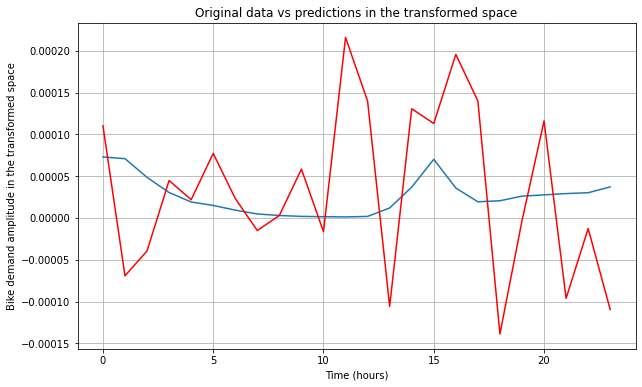

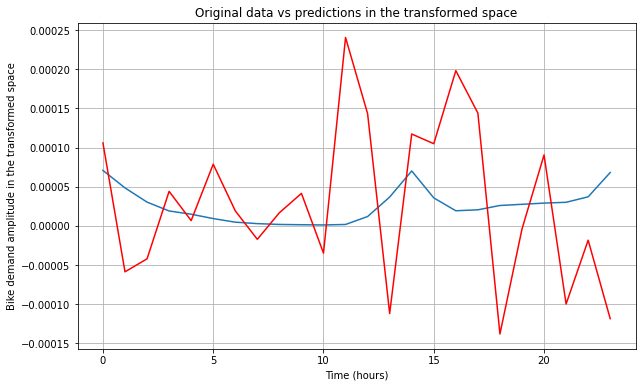

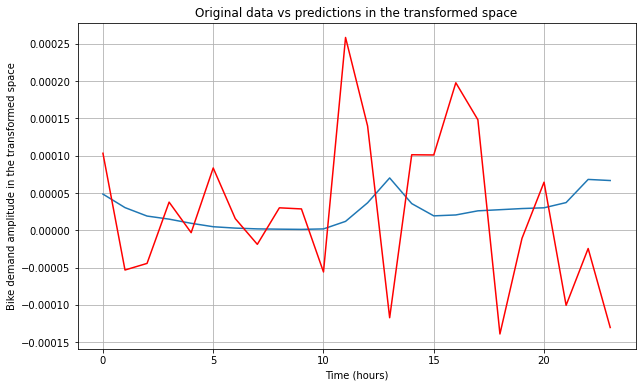

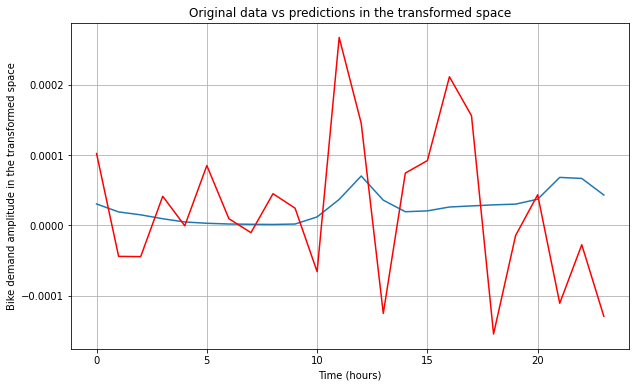

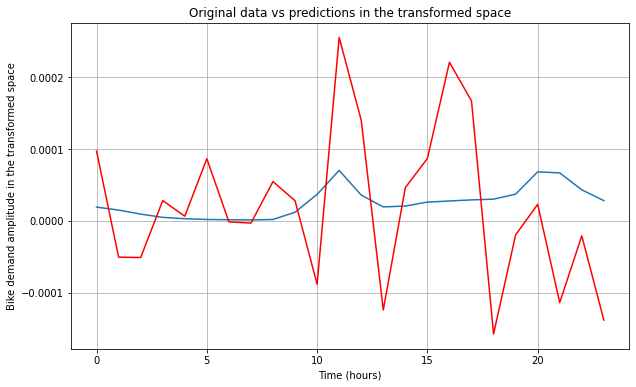

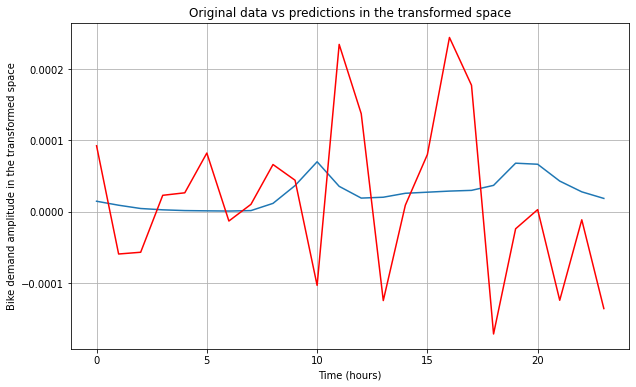

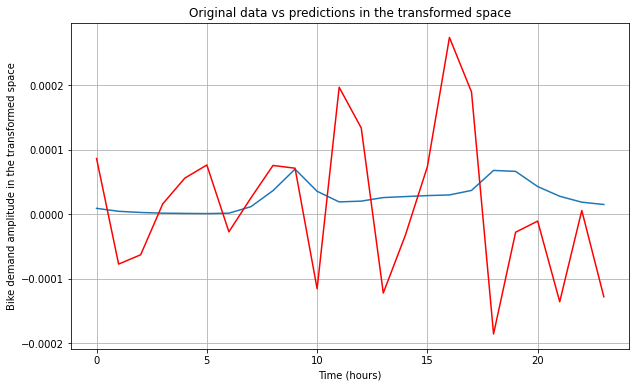

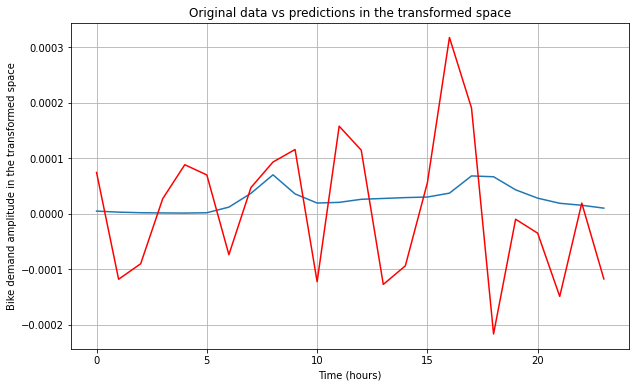

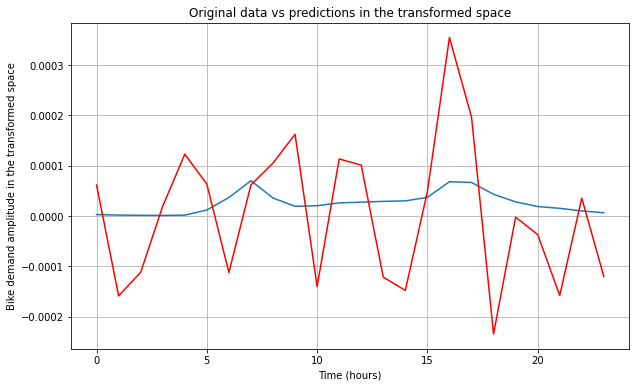

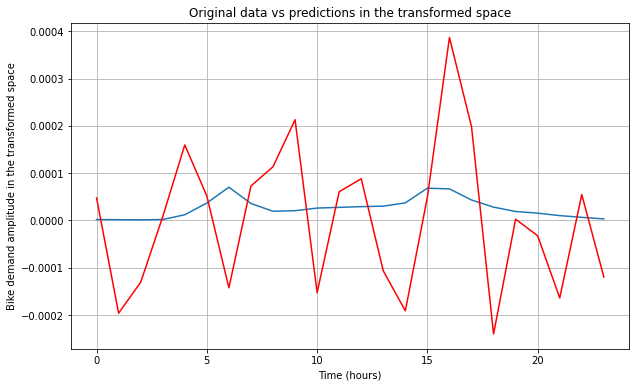

In [95]:
y_pred = model_2.predict(X_test)

for i in range(0,24):
  the_hour = i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')

# j

In [175]:
def vanilla_multistep_LSTM():
    model = Sequential()  
    model.add(LSTM(units=50, input_shape=(lookback, X_train.shape[-1])))
    model.add(Dense(time_step))
    return model

In [176]:
loss = 'mean_squared_error'
optimizer = "adam"

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

In [177]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer=optimizer, 
              loss=loss,
              metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                12400     
                                                                 
 dense_9 (Dense)             (None, 24)                1224      
                                                                 
Total params: 13,624
Trainable params: 13,624
Non-trainable params: 0
_________________________________________________________________
0.001


In [178]:
history_model_0 = model.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
391/391 [==============================] - 51s 27ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 6.9255e-05 - val_mse: 6.9255e-05
Epoch 2/35
391/391 [==============================] - 10s 24ms/step - loss: 4.0936e-05 - mse: 4.0936e-05 - val_loss: 2.5856e-05 - val_mse: 2.5856e-05
Epoch 3/35
391/391 [==============================] - 9s 24ms/step - loss: 1.8720e-05 - mse: 1.8720e-05 - val_loss: 1.4089e-05 - val_mse: 1.4089e-05
Epoch 4/35
391/391 [==============================] - 9s 24ms/step - loss: 1.0916e-05 - mse: 1.0916e-05 - val_loss: 9.1649e-06 - val_mse: 9.1649e-06
Epoch 5/35
391/391 [==============================] - 10s 26ms/step - loss: 7.1445e-06 - mse: 7.1445e-06 - val_loss: 6.2765e-06 - val_mse: 6.2765e-06
Epoch 6/35
391/391 [==============================] - 9s 24ms/step - loss: 5.0281e-06 - mse: 5.0281e-06 - val_loss: 4.6670e-06 - val_mse: 4.6670e-06
Epoch 7/35
391/391 [==============================] - 9s 24ms/step - loss: 3.6665e-06 - mse: 3.6665e-06 - val_l

In [179]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
109/109 [==============================] - 1s 8ms/step - loss: nan - mse: nan          
Test MSE: nan
Test MAE: nan


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

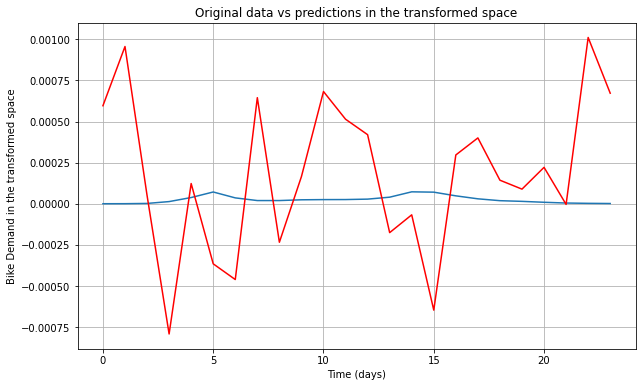

In [180]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Bike Demand in the transformed space')
plt.title('Original data vs predictions in the transformed space')

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

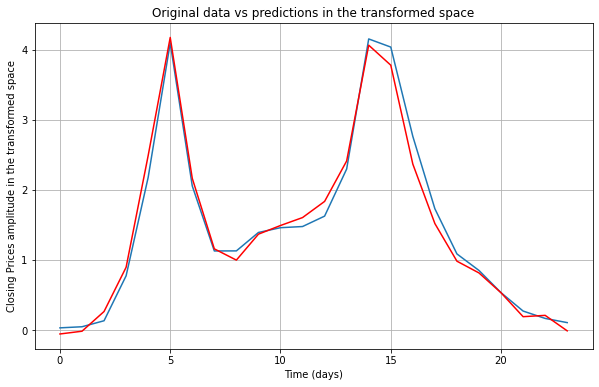

In [ ]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_hour = 0
y_pred_hour = y_pred[the_day,:]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

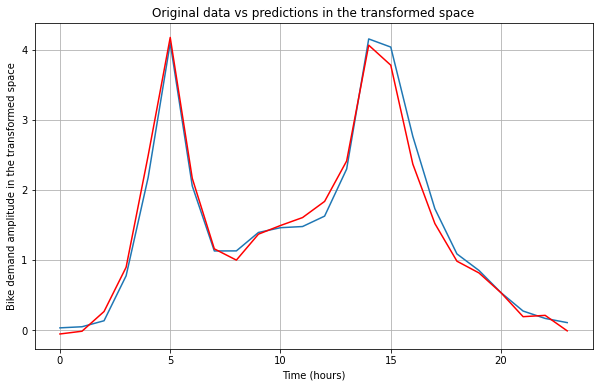

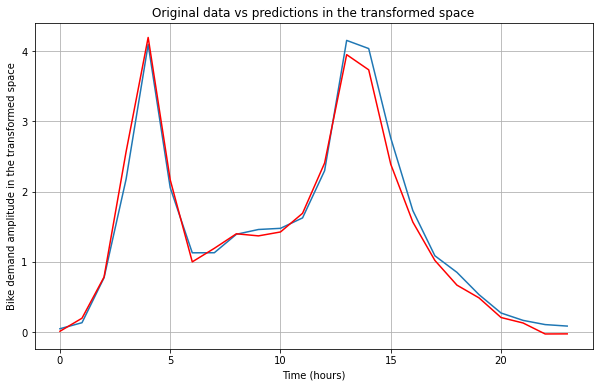

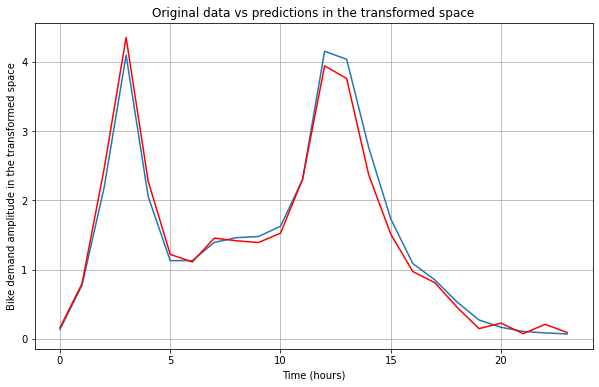

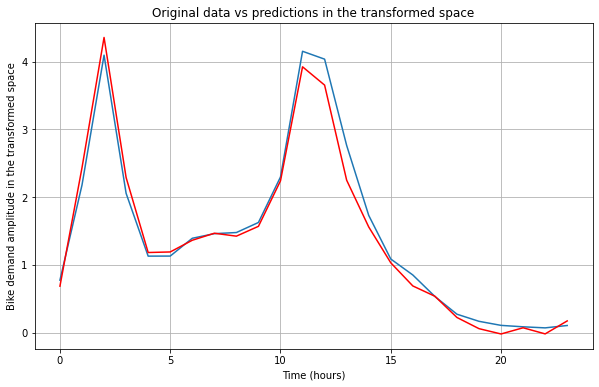

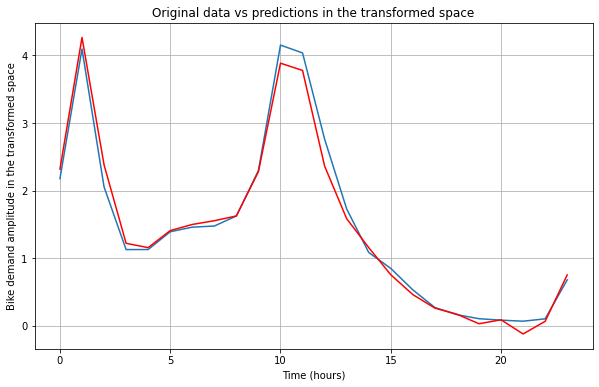

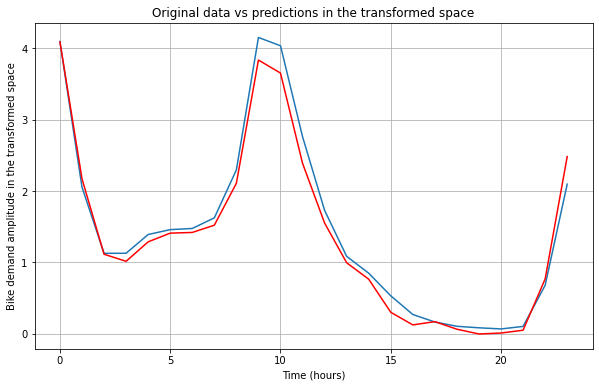

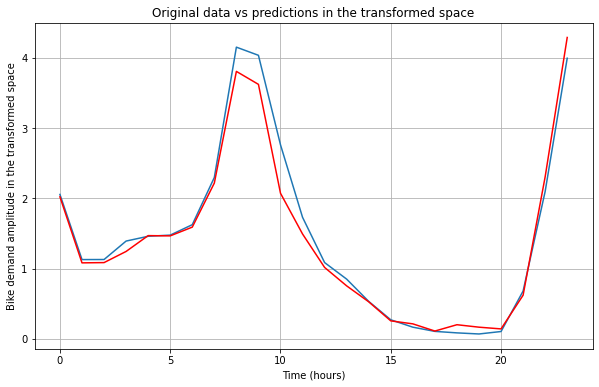

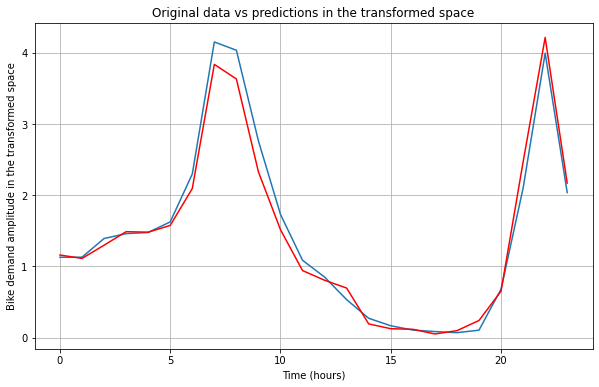

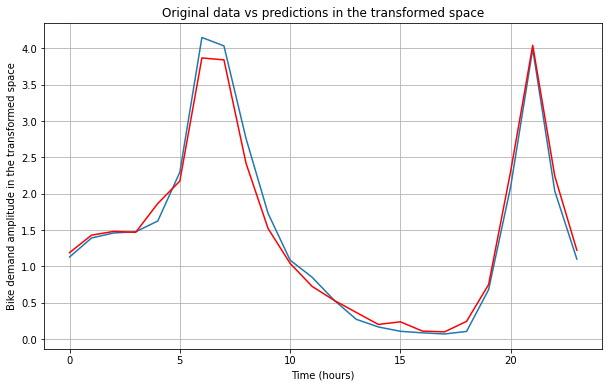

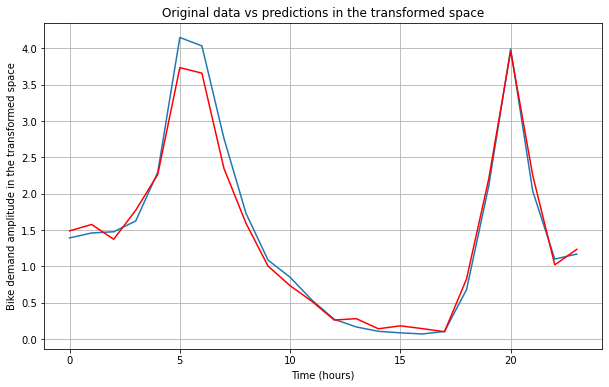

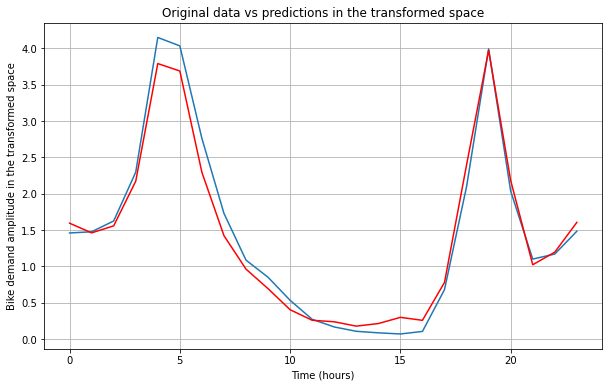

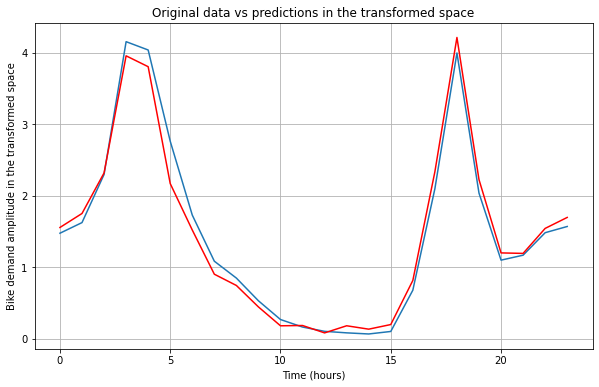

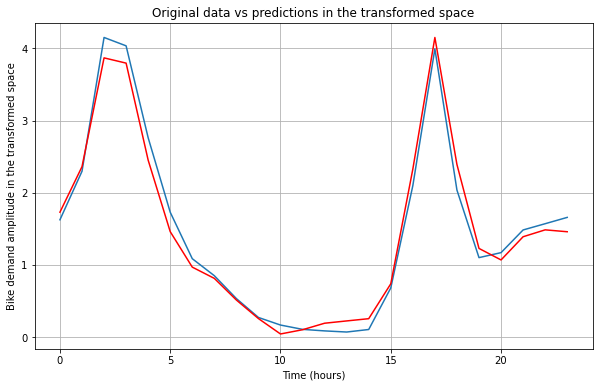

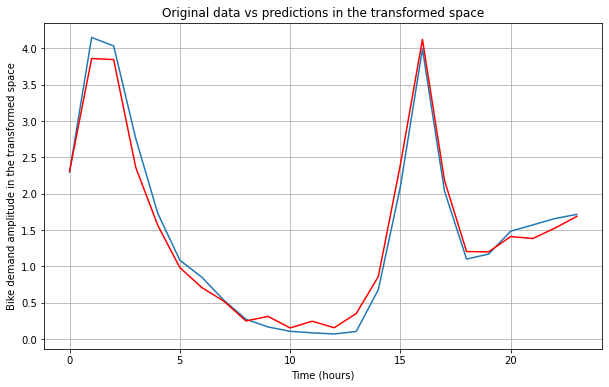

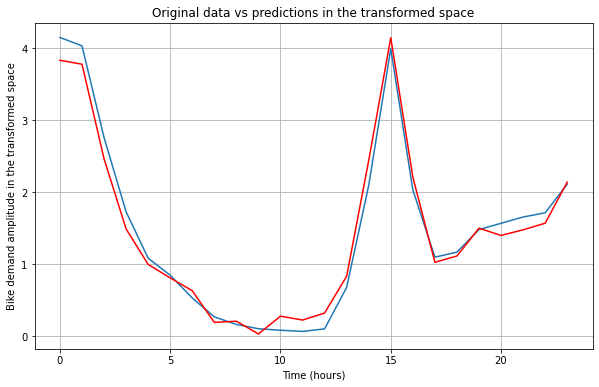

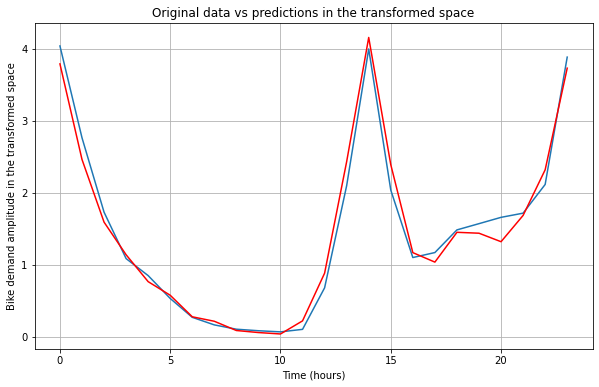

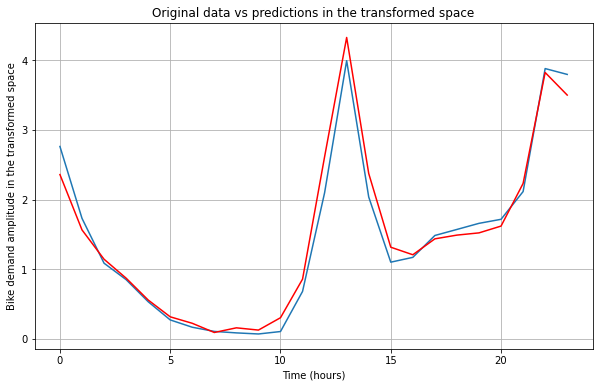

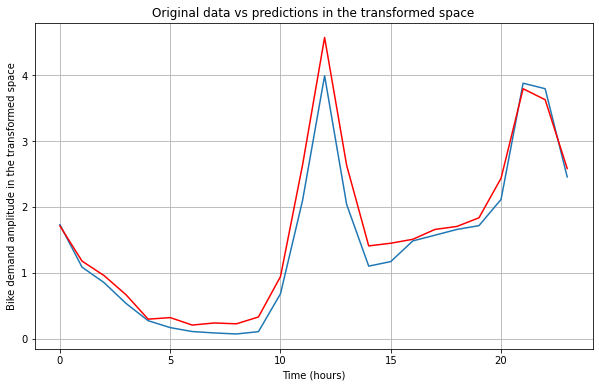

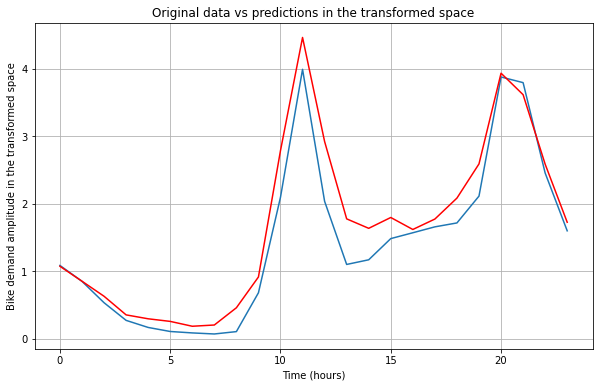

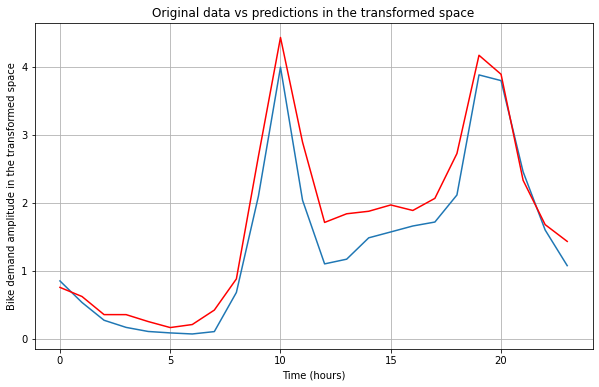

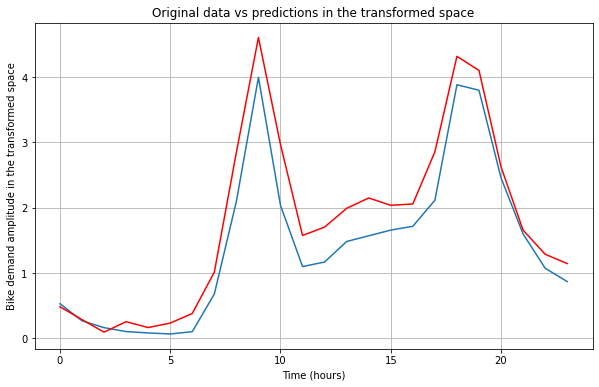

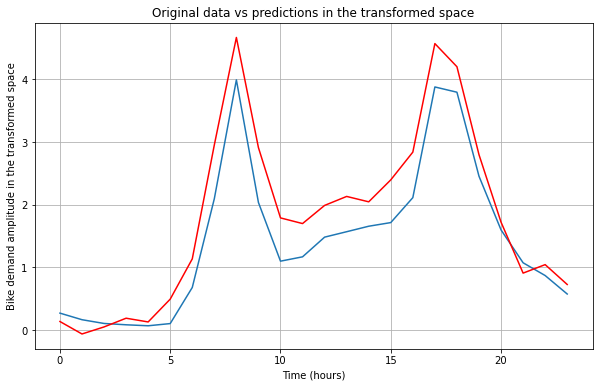

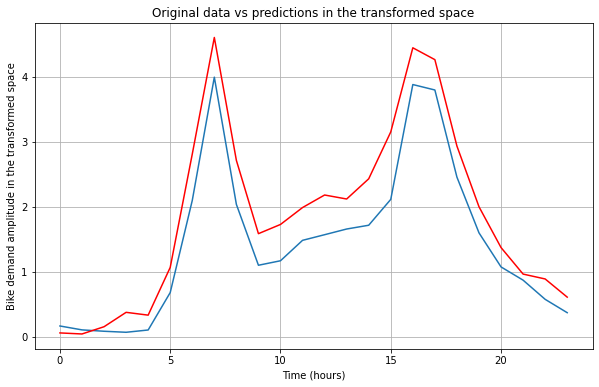

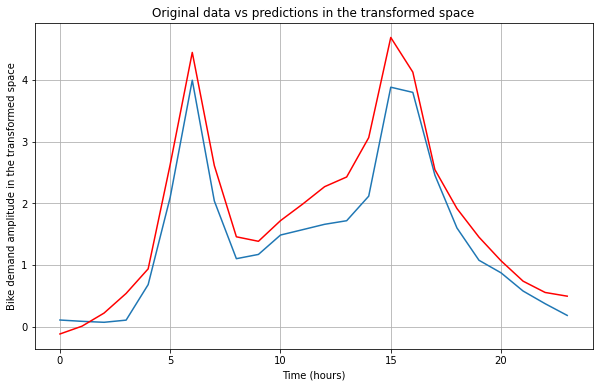

In [ ]:
for i in range(0,24):
  the_hour = i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')